In [57]:
import numpy as np
import scipy.stats as sts
import scipy.special as spec
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.integrate as integral
import pandas as pd
import statsmodels.api as sm
import numpy.linalg as lin
%matplotlib notebook

In [58]:
#input data
dt = pd.read_excel('data.xlsx')
dt.head()

,quarter,Inflation,interest rate,Output Gap
0,1,2.1,3.933333,3.893743
1,2,1.8,3.696667,3.779925
2,3,1.2,2.936667,3.817533
3,4,1.0,2.296667,1.594366
4,5,0.8,2.003333,0.297382


In [59]:
#defined model function to simulate model data
S = 2200
def model(sai_b, sai_i, eta, kappa, alpha_pi, gamma, mu_i, mu_pi, mu_y):
    interest_rate_lag = 3.99
    b = np.zeros(S)
    pi_c = np.zeros(S)
    pi_c[0] = 2.23
    b[0] = 0
    
    
    interest_rate = np.zeros(S)
    pi = np.zeros(S)
    y = np.zeros(S)
    f = np.zeros(S-1)
    
    
    for i in range(S):
        y[i] = eta*b[i]
        pi[i] = pi_c[i] + kappa*y[i]
        interest_rate[i] = mu_i * interest_rate_lag + (1-mu_i) * (5 + mu_pi * (pi[i] - 2.5) + mu_y * y[i])
        
        if i < S-1:
            pi_c[i+1] = pi_c[i] + alpha_pi * (gamma*2.5 + (1-gamma) * pi[i] - pi_c[i])
            
            f[i] = sai_b*b[i] - sai_i*(interest_rate[i] - pi[i] - 2.5)
            probnp = min(1,0.125*np.exp(f[i]))
            probpn = min(1,0.125*np.exp(-f[i]))
            b[i+1] = b[i] + (1-b[i])*probnp - (1+b[i])*probpn
        
        interest_rate_lag = interest_rate[i]
        
    return y[200:], pi[200:], interest_rate[200:], f

In [60]:
#use simulated model data to compute model moment
def model_moment(sai_b, sai_i, eta, kappa, alpha_pi, gamma, mu_i, mu_pi, mu_y):
    y_mod, pi_mod, ir_mod, f = model(sai_b, sai_i, eta, kappa, alpha_pi, gamma, mu_i, mu_pi, mu_y)
    
    covYY_mod = np.zeros(9)
    covII_mod = np.zeros(9)
    covPP_mod = np.zeros(9)
    covYI_mod = np.zeros(9)
    covYP_mod = np.zeros(9)
    covIP_mod = np.zeros(9)
    covIY_mod = np.zeros(8)
    covPY_mod = np.zeros(8)
    covPI_mod = np.zeros(8)
    
    for i in range(9):
        covYY_mod[i] = np.cov(y_mod[i:2000], y_mod[:2000-i])[0][1]
    
    for i in range(9):
        covII_mod[i] = np.cov(ir_mod[i:2000], ir_mod[:2000-i])[0][1]
    
    for i in range(9):
        covPP_mod[i] = np.cov(pi_mod[i:2000], pi_mod[:2000-i])[0][1]

    for i in range(9):
        covYI_mod[i] = np.cov(y_mod[i:2000], ir_mod[:2000-i])[0][1]
    
    for i in range(9):
        covYP_mod[i] = np.cov(y_mod[i:2000], pi_mod[:2000-i])[0][1]
    
    for i in range(9):
        covIP_mod[i] = np.cov(ir_mod[i:2000], pi_mod[:2000-i])[0][1]
    
    for i in range(1,9):
        covIY_mod[i-1] = np.cov(ir_mod[i:2000], y_mod[:2000-i])[0][1]
    
    for i in range(1,9):
        covPY_mod[i-1] = np.cov(pi_mod[i:2000], y_mod[:2000-i])[0][1]
    
    for i in range(1,9):
        covPI_mod[i-1] = np.cov(pi_mod[i:2000], ir_mod[:2000-i])[0][1]
        
    a = np.zeros(S-1)
    b = np.zeros(S-1)
    
    for i in range(S-1):
        a[i] = max(0, 0.125*np.exp(f[i]) - 1)
        b[i] = max(0, 0.125*np.exp(-f[i]) - 1)
        
    c = a + b   
    M = c.mean()
    
    return covYY_mod, covII_mod, covPP_mod, covYI_mod, covYP_mod, covIP_mod, covIY_mod, covPY_mod, covPI_mod, M

In [61]:
#compute data moment
dt_y = dt['Output Gap'].values
dt_p = dt.Inflation.values
dt_i = dt['interest rate'].values

covYY = np.zeros(9)
covII = np.zeros(9)
covPP = np.zeros(9)
covYI = np.zeros(9)
covYP = np.zeros(9)
covIP = np.zeros(9)
covIY = np.zeros(8)
covPY = np.zeros(8)
covPI = np.zeros(8)


for i in range(9):
    covYY[i] = np.cov(dt_y[i:78], dt_y[:78-i])[0][1]
    
for i in range(9):
    covII[i] = np.cov(dt_i[i:78], dt_i[:78-i])[0][1]
    
for i in range(9):
    covPP[i] = np.cov(dt_p[i:78], dt_p[:78-i])[0][1]

for i in range(9):
    covYI[i] = np.cov(dt_y[i:78], dt_i[:78-i])[0][1]
    
for i in range(9):
    covYP[i] = np.cov(dt_y[i:78], dt_p[:78-i])[0][1]
    
for i in range(9):
    covIP[i] = np.cov(dt_i[i:78], dt_p[:78-i])[0][1]
    
for i in range(1,9):
    covIY[i-1] = np.cov(dt_i[i:78], dt_y[:78-i])[0][1]
    
for i in range(1,9):
    covPY[i-1] = np.cov(dt_p[i:78], dt_y[:78-i])[0][1]
    
for i in range(1,9):
    covPI[i-1] = np.cov(dt_p[i:78], dt_i[:78-i])[0][1]

In [62]:
#Compute the error vector
def err_vec(sai_b, sai_i, eta, kappa, alpha_pi, gamma, mu_i, mu_pi, mu_y):
    covYY_mod, covII_mod, covPP_mod, covYI_mod, covYP_mod, covIP_mod, covIY_mod, covPY_mod, covPI_mod, M = model_moment(sai_b, sai_i, eta, kappa, alpha_pi, gamma, mu_i, mu_pi, mu_y)
    err_vec = np.append(covYY_mod-covYY, covII_mod-covII)
    err_vec = np.append(err_vec, covPP_mod - covPP)
    err_vec = np.append(err_vec, covYI_mod - covYI)
    err_vec = np.append(err_vec, covYP_mod - covYP)
    err_vec = np.append(err_vec, covIP_mod - covIP)
    err_vec = np.append(err_vec, covIY_mod - covIY)
    err_vec = np.append(err_vec, covPY_mod - covPY)
    err_vec = np.append(err_vec, covPI_mod - covPI)
    err_vec = np.append(err_vec, M)
    
    return err_vec

In [63]:
#Compute criterion function
def crit(params, *args):
    sai_b, sai_i, eta, kappa, alpha_pi, gamma, mu_i, mu_pi, mu_y = params
    W_hat = args
    
    err = err_vec(sai_b, sai_i, eta, kappa, alpha_pi, gamma, mu_i, mu_pi, mu_y)
    
    crit_val = np.dot(np.dot(err.T, W_hat), err)
    
    return crit_val

In [64]:
# Since we want to use the Iterated variance covariance estimator, then we first estimate the
# parameters by using the Identity Matrix
W_Id = np.eye(79)
W_Id[78,78] = 1000
sai_b_init = 0.726
sai_i_init = 2.962
eta_init = 1.841
kappa_init = 0.243
alpha_pi_init = 1
gamma_init = 0
mu_i_init = 0.717
mu_pi_init = 1.46
mu_y_init = 0.627

params_init = np.array([sai_b_init, sai_i_init, eta_init, kappa_init, alpha_pi_init, gamma_init, mu_i_init, mu_pi_init, mu_y_init])
W_hat = W_Id

results = opt.minimize(crit, params_init, args=(W_hat), method='L-BFGS-B',bounds=((0, 5), (1e-2, 15),(1e-2,None),\
                                                                                  (1e-2,1), (0,1),(0,1),(1e-2,1),\
                                                                                  (1e-2,4),(1e-2,5)))

In [65]:
results

      fun: array([ 167.21518717])
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.96972348e+00,   2.11251461e+00,   3.22883977e+00,
         1.01586184e+02,  -1.00758541e+01,   2.56180274e+03,
        -9.38245961e+01,   2.83719447e+02,   7.22874347e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2180
      nit: 139
   status: 0
  success: True
        x: array([ 0.14772197,  3.64437461,  2.9149947 ,  0.14639696,  0.90203864,
        0.        ,  0.85054931,  1.04744761,  0.67235986])

In [66]:
y,pi,i,f = model(0.14772197,  3.64437461,  2.9149947 ,  0.14639696,  0.90203864,
        0.        ,  0.85054931,  1.04744761,  0.67235986)

In [67]:
x = list(range(100))

<IPython.core.display.Javascript object>


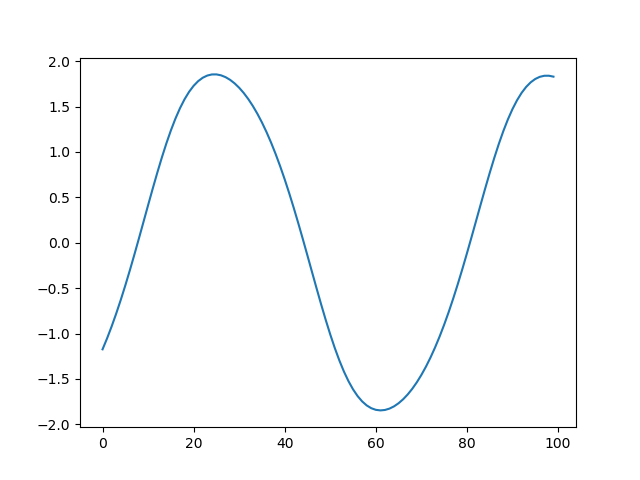

In [68]:
plt.plot(x,y[:100])
plt.show()